# Load Packages and Utilities

In [0]:
!pip install --upgrade pip
!pip uninstall -y tensorflow grpcio google-auth
!pip install --upgrade grpcio==1.24.3 google-auth==1.6.3 google-colab tensorflow==2.1
!pip install --upgrade matplotlib pandas h5py sklearn tqdm bleach pillow
!pip install --ignore-installed --upgrade seaborn

In [0]:
import functools
import os
import platform
import random
import shutil
import sys
import datetime

# data-science & processing tools
import numpy as np
import pandas as pd
import sklearn.metrics
import h5py

# progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm_notebook as tqdm

# plotting utilities
import seaborn as sns
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf
import tensorflow.keras as K

# required TensorFlow version >= 2.0.0
tf_version = tf.__version__
print('TensorFlow version: {}'.format(tf_version))
assert int(tf_version[0]) >= 2, "Tensorflow version must be >= 2.0"

# seed random numbers for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print('\nImports Complete.')

%matplotlib inline
random.seed(0)

# Load Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

my_data_dir = '/content/drive/My Drive/6874_FinalProject/latent_representation/'

In [0]:
X = np.loadtxt(my_data_dir + 'bw_smalllatent_train.txt')
X_test = np.loadtxt(my_data_dir + 'bw_smalllatent_test.txt')
class_label = np.loadtxt(my_data_dir + 'bw_smally_train.txt')
class_label_test = np.loadtxt(my_data_dir + 'bw_smally_test.txt')

X = np.append(X, X_test, axis=0)
class_label = np.append(class_label, class_label_test, axis=0)

print_var(X.shape, 'gene expression matrix shape')
print_var(class_label.shape, 'class labels shape')

In [0]:
X = X[:18285,:]
class_label = class_label[:18285]

## Potentially Add PCA reduction layer

In [0]:
from sklearn.decomposition import PCA
X = PCA(n_components=60).fit_transform(X)

# Clustering for Autoencoder 1

In [0]:
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf

In [0]:
X = np.loadtxt(my_data_dir + 'bw_largelatent_train.txt')
X_test = np.loadtxt(my_data_dir + 'bw_largelatent_test.txt')
class_label = np.loadtxt(my_data_dir + 'bw_largey_train.txt')
class_label_test = np.loadtxt(my_data_dir + 'bw_largey_test.txt')

X = np.append(X, X_test, axis=0)
class_label = np.append(class_label, class_label_test, axis=0)

print_var(X.shape, 'gene expression matrix shape')
print_var(class_label.shape, 'class labels shape')

class_label[class_label == 0] = 100
class_label[class_label == 1] = 0
class_label[class_label == 100] = 1

confirm_cell_completion('Data Loaded.')

            gene expression matrix shape = (18287, 1352)
                      class labels shape = (18287,)

[05/04 @ 14:29:09] - Data Loaded.


In [0]:
Sum_of_squared_distances = []
K = range(1,31)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    print("iteration {} done".format(k))
    Sum_of_squared_distances.append(km.inertia_)

iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done
iteration 10 done
iteration 11 done
iteration 12 done
iteration 13 done
iteration 14 done
iteration 15 done
iteration 16 done
iteration 17 done
iteration 18 done
iteration 19 done
iteration 20 done
iteration 21 done
iteration 22 done
iteration 23 done
iteration 24 done
iteration 25 done
iteration 26 done
iteration 27 done
iteration 28 done
iteration 29 done
iteration 30 done


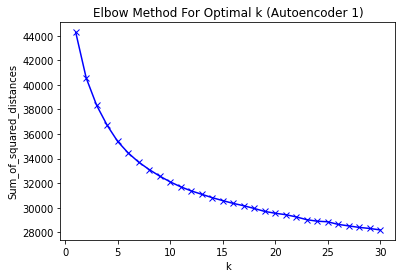

In [0]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Autoencoder 1)')
plt.show()

In [0]:
km = KMeans(n_clusters=15)
km = km.fit(X)

In [0]:
x_ticks = ['BAS', 'EBO',	'EOS',	'KSC',	'LYA',	'LYT',	'MMZ',	'MOB',	'MON',	'MYB',	'MYO',	'NGB',	'NGS',	'PMB',	'PMO']

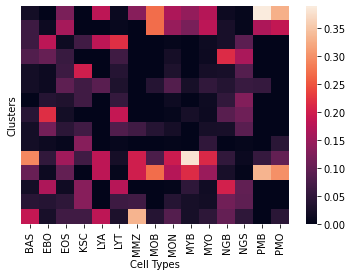

In [0]:
test_crosstab = pd.crosstab(km.labels_, class_label, normalize='columns')
test_crosstab.columns = test_crosstab.columns.rename('Cell Types')
test_crosstab.index = test_crosstab.index.rename('Clusters')
sns.heatmap(test_crosstab, annot=False, xticklabels=x_ticks, yticklabels=False)

## Load Autoencoder 1 to Create Cluster Representatives

In [0]:
# import Keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import optimizers
from keras import backend as K
from keras.models import model_from_json
json_file = open("/content/drive/My Drive/6874_FinalProject/autoencoder_large.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/6874_FinalProject/autoencoder_large.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [0]:
encoded_input = Input(shape=(13, 13, 8))
decode = loaded_model.layers[-9](encoded_input)
decode = loaded_model.layers[-8](decode)
decode = loaded_model.layers[-7](decode)
decode = loaded_model.layers[-6](decode)
decode = loaded_model.layers[-5](decode)
decode = loaded_model.layers[-4](decode)
decode = loaded_model.layers[-3](decode)
decode = loaded_model.layers[-2](decode)
decode = loaded_model.layers[-1](decode)

autodecoder = Model(encoded_input, decode)

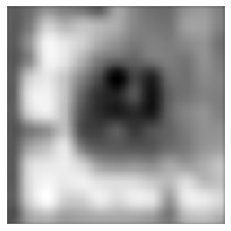

In [0]:
X_sub = tf.math.reduce_min(X[km.labels_ ==0,:], axis=0)
X_resh = tf.reshape(X_sub, (1,13,13,8))
X_encod = autodecoder.predict(X_resh, steps=1)
X_encod = tf.squeeze(X_encod)
plt.imshow(X_encod)
plt.gray()
plt.axis('off')
plt.show()

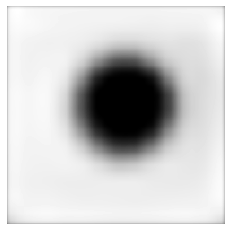

In [0]:
X_sub = tf.math.reduce_mean(X[km.labels_ ==0,:], axis=0)
X_resh = tf.reshape(X_sub, (1,13,13,8))
X_encod = autodecoder.predict(X_resh, steps=1)
X_encod = tf.squeeze(X_encod)
plt.imshow(X_encod)
plt.gray()
plt.axis('off')
plt.show()

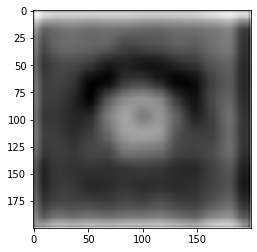

In [0]:
X_sub = tf.math.reduce_std(X[km.labels_ ==0,:], axis=0)
X_resh = tf.reshape(X_sub, (1,13,13,8))
X_encod = autodecoder.predict(X_resh, steps=1)
X_encod = tf.squeeze(X_encod)
plt.imshow(X_encod)
plt.gray()
plt.axis('off')
plt.show()

### Images With Averaging After Decoding

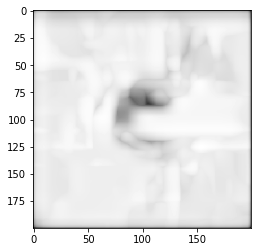

In [0]:
X_sub = X[km.labels_ ==0,:]
X_resh = tf.reshape(X_sub, (X_sub.shape[0],13,13,8))
X_encod = autodecoder.predict(X_resh, steps=1)
X_encod = tf.math.reduce_max(tf.squeeze(X_encod), axis=0)
plt.imshow(X_encod)
plt.gray()
plt.axis('off')
plt.show()

# Splitting Into Binary Cell Categories
## Typical vs Atypical Cell Types

In [0]:
typical_atypical_label = class_label
typical_atypical_label[np.isin(typical_atypical_label, [1,4,6,7,9,10,13,14])] = 1
typical_atypical_label[typical_atypical_label != 1] = 0
km2 = KMeans(n_clusters=2)
km2 = km2.fit(X)

In [0]:
typ_atyp_cross = pd.crosstab(km2.labels_, typical_atypical_label, normalize='columns')
typ_atyp_cross.columns = typ_atyp_cross.columns.rename('Cell Types')
typ_atyp_cross.index = typ_atyp_cross.index.rename('Clusters')

In [0]:
typ_atyp_cross

Cell Types,0.0,1.0
Clusters,,
0,0.244529,0.795351
1,0.755471,0.204649


In [0]:
print(typical_atypical_label[typical_atypical_label==0].shape)
print(typical_atypical_label[typical_atypical_label==1].shape)

(14759,)
(3528,)


### Cluster Images

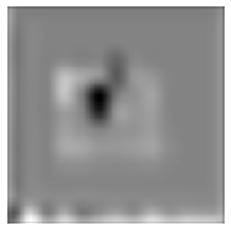

In [0]:
X_sub = tf.math.reduce_min(X[km2.labels_ ==0,:], axis=0)
X_resh = tf.reshape(X_sub, (1,13,13,8))
X_encod = autodecoder.predict(X_resh, steps=1)
X_encod = tf.squeeze(X_encod)
plt.imshow(X_encod)
plt.gray()
plt.axis('off')
plt.show()

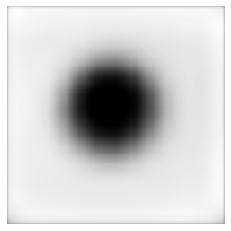

In [0]:
X_sub = tf.math.reduce_mean(X[km2.labels_ ==0,:], axis=0)
X_resh = tf.reshape(X_sub, (1,13,13,8))
X_encod = autodecoder.predict(X_resh, steps=1)
X_encod = tf.squeeze(X_encod)
plt.imshow(X_encod)
plt.gray()
plt.axis('off')
plt.show()

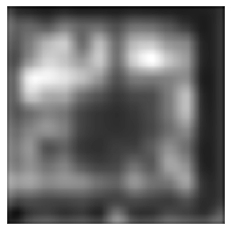

In [0]:
X_sub = tf.math.reduce_min(X[km2.labels_ ==1,:], axis=0)
X_resh = tf.reshape(X_sub, (1,13,13,8))
X_encod = autodecoder.predict(X_resh, steps=1)
X_encod = tf.squeeze(X_encod)
plt.imshow(X_encod)
plt.gray()
plt.axis('off')
plt.show()

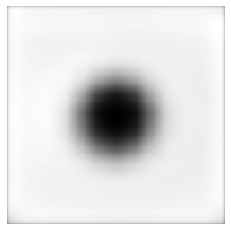

In [0]:
X_sub = tf.math.reduce_mean(X[km2.labels_ ==1,:], axis=0)
X_resh = tf.reshape(X_sub, (1,13,13,8))
X_encod = autodecoder.predict(X_resh, steps=1)
X_encod = tf.squeeze(X_encod)
plt.imshow(X_encod)
plt.gray()
plt.axis('off')
plt.show()

In [0]:
print(km2.labels_[km2.labels_ ==0].shape)
print(km2.labels_[km2.labels_ ==1].shape)

(6415,)
(11872,)


## Mature vs Immature

In [0]:
mat_immat_label = class_label
mat_immat_label[np.isin(mat_immat_label, [1,3,6,7,9,10,13,14])] = 1
mat_immat_label[mat_immat_label != 1] = 0
km2 = KMeans(n_clusters=2)
km2 = km2.fit(X)
mat_immat_cross = pd.crosstab(km2.labels_, mat_immat_label, normalize='columns')
mat_immat_cross.columns = mat_immat_cross.columns.rename('Cell Types')
mat_immat_cross.index = mat_immat_cross.index.rename('Clusters')

In [0]:
mat_immat_cross

Cell Types,0.0,1.0
Clusters,,
0,0.753642,0.204082
1,0.246358,0.795918
